# How a Transformer Computes the Cumulative Sum
**Author:** Dan Wilhelm [dan@danwilhelm.com]

We investigate how a one-layer attention+feed-forward transformer computes the cumulative sum. I've written the investigation conversationally, providing numerous examples and insights.

Of particular interest, we:
1. design a 38-weight attention-only circuit with smaller loss than the provided model;
2. prove that an equally-attended attention block is equivalent to a single linear projection (of the prior-input mean!); and
3. provide an independent transformer implementation to make it easier to modify the internals.

Thank you to the author Callum McDougall! I have been reverse-engineering significantly more complex transformers for a while now, so this was a nice break. You may find more information about the challenge and monthly problem series here: 
- [Problem GitHub page](https://github.com/callummcdougall/ARENA_2.0/tree/main/chapter1_transformers/exercises/monthly_algorithmic_problems/november23_cumsum)
- [ARENA page](https://arena-ch1-transformers.streamlit.app/Monthly_Algorithmic_Problems)
- [eindex dependency (needed to run the provided model)](https://github.com/callummcdougall/eindex/tree/main)


## Table of Contents
0. [Introduction](#intro)
1. [All 24 embedding channels directly encode token sign and magnitude](#embeds)
2. [Attention softmax equally attends to each token](#softmax)
3. [Equally-divided attention computes the cumulative mean](#mean)
4. [Feed-forward network "cleans up" the signal](#ffn)
5. [What about the zero unembed pattern?](#unembeds)
6. [Designing a 38-weight attention-only cumsum circuit](#newnet)
7. [(Appendix) Rewriting two linear transforms as one](#proof)

# Introduction<a class="anchor" id="intro"></a>

## The Problem

- We are given a sequence $S$ of integers between -5 and 5, inclusive, where $|S| \le 20$.

- For each index $i$, we must determine whether the cumulative sum $S_{\leq i}$ is positive, zero, or negative.

- This can be accomplished by simply summing the subsequence and testing the resulting sign.

## Mechanism

It makes sense to hypothesize a solution is feasible. After all, transformers provide us with:

1. Dot products -- perfect for summing together numbers, and 
2. Pattern detectors -- perfect to detect positive/negative/zero.

We will prove below that the network works as follows:

1. **Embedding.** The magnitude and sign of each integer is directly encoded into each of the 24 embedding channels.
2. **Attention.** Each prior token is equally attended to. In this special case, the attention block outputs a linear combination of the _mean_ of the prior inputs.
3. **Feed-forward.** A few residual stream signs might be slightly incorrect due to noise*. So, these are error-corrected and boosted to ensure an exact unembed pattern match.
3. **Unembedding.** Now that the sign-corrected mean is on the residual stream, we compare its sign to positive/negative/zero patterns.

\* Substantial noise is introduced by non-zero biases, imperfectly linear embeddings, non-zero positional embeddings, the summed prior residual stream value, and inherent error in the weights.

We will later use our learnings by accomplishing the same with a simple 39-weight network (using a two-dimensional embedding and no MLP sub-block).

## What does the residual stream represent?

Transformers often represent information differently at various points in the residual stream. In this particular circuit, each channel stores nearly-identical information but with a different proportionality and sign. In fact, it is quite useful to consider each channel as storing separately a magnitude and sign. There are two overall spaces -- the embedding space and the post-attention/unembedding space.

1. **Embedding.** Initially, the magnitude and sign of each token is stored directly. The input token's sign is matched in channels 0, 1, 4, 8, 12, 13, 14, 15, 16, 17, 19, 21, and 23; the other channels have opposite sign.
2. **Post-Attention.** Each channel's magnitude now contains a scaled mean of the prior embeddings. However, the attention projections deterministically flip the sign of each channel. Now, the mean's sign is matched in channels 0, 1, 9, 12, 13, 14, 15, 17, 18, 19, 20, and 23; the other channels have opposing sign.
3. **Post-Feedforward.** The feedforward network outputs nearly exactly what it matches (yet larger-magnitude). So, signs are retained.
3. **Unembedding.** The three unembedding patterns (neg/zero/pos) identically match the signs outputted by the attention and MLP sub-blocks.

## What about zero?

We just discussed how positive and negative are represented by particular channels having particular signs at particular places in the network.

However, zero is primarily represented by small magnitudes. These small magnitudes lead to small activations, which make the attention and feedforward biases more prominent. The signs of these biases then near-perfectly match the signs of the "zero" pattern in the unembedding stage. This perhaps is similar to how logistic regression has an underlying "reference case" whose frequency is encoded in the bias.

What about in the feedforward stage? The "zero" pattern shares ~half of the signs with each positive and negative embed pattern. So, it slightly activates all of the feedforward network's hidden neurons, resulting in the output being the ~mean of all pos/neg outputs -- which is close to zero per channel.

# Initialization

In [1]:
from cumsum_model import CumsumModel
from cumsum_utils import where, rowplot, listplot, hline
from transformer_lens import HookedTransformer

import numpy as np
import matplotlib.pyplot as plt

import os
import sys
import torch as t
from pathlib import Path
from eindex import eindex

# Make sure exercises are in the path
#chapter = r"chapter1_transformers"
#exercises_dir = Path(f"{os.getcwd().split(chapter)[0]}/{chapter}/exercises").resolve()
section_dir = "./monthly_algorithmic_problems/november23_cumsum"
#if str(exercises_dir) not in sys.path: sys.path.append(str(exercises_dir))

from monthly_algorithmic_problems.november23_cumsum.dataset import CumsumDataset
from monthly_algorithmic_problems.november23_cumsum.model import create_model
from monthly_algorithmic_problems.plotly_utils import hist, bar, imshow

def fix_dataset(dataset: CumsumDataset):
    dataset.toks += dataset.max_value

def fix_model(model: HookedTransformer):
    max_value = model.W_E.shape[0] // 2
    model.embed.W_E.data = t.concat([model.W_E[-max_value:], model.W_E[:-max_value]])

device = "cpu"

In [2]:
# Load given model from disk
filename = section_dir + "/cumsum_model.pt"

model = create_model(
    max_value=5,
    seq_len=20,
    seed=0,
    d_model=24,
    d_head=12,
    n_layers=1,
    n_heads=1,
    normalization_type=None,
    d_mlp=8,
    device=device
)

state_dict = t.load(filename)

state_dict = model.center_writing_weights(t.load(filename))
state_dict = model.center_unembed(state_dict)
state_dict = model.fold_value_biases(state_dict)
model.load_state_dict(state_dict, strict=False);
fix_model(model)

In [3]:
# Verify that the given model and our independent implementation perform identically

def test_actual(model, dataset):
    'Display overall stats of given model on test dataset'
    logits, cache = model.run_with_cache(dataset.toks)

    logprobs = logits.log_softmax(-1) # [batch seq_len vocab_out]
    probs = logprobs.softmax(-1)

    batch_size, seq_len = dataset.toks.shape
    logprobs_correct = eindex(logprobs, dataset.labels, "batch seq [batch seq]")
    probs_correct = eindex(probs, dataset.labels, "batch seq [batch seq]")

    print(f"Average cross entropy loss: {-logprobs_correct.mean().item():.3f}")
    print(f"Mean probability on correct label: {probs_correct.mean():.3f}")
    print(f"Median probability on correct label: {probs_correct.median():.3f}")
    print(f"Min probability on correct label: {probs_correct.min():.3f}")


def test_impl(model, dataset):
    'Display overall stats of independent model on test dataset'
    rows = np.array([d[0] for d in dataset])
    labels = np.array([d[1] for d in dataset])

    probs_correct = np.zeros(rows.shape)
    logprobs_correct = np.zeros_like(probs_correct)

    # Run each input through the model
    total_incorrect = 0
    for i,(X,y_true) in enumerate(zip(rows, labels)):
        model.run(X)
        if np.any(y_true != model.labels):               # Display any mislabelings
            print('INCORRECT RESULT:', model.toks_in, y_true, model.labels)
            total_incorrect += 1
        probs_correct[i] = model.probs_correct       # Store only the probability of the most-probable class
        logprobs_correct[i] = model.logprobs_correct
        #if np.any(probs_correct[i] < 0.55): print(list(model.toks_in), y_true, model.labels)

    print(f"Average cross entropy loss: {-logprobs_correct.mean():.3f}")
    print(f"Mean probability on correct label: {np.mean(probs_correct):.3f}")
    print(f"Median probability on correct label: {np.median(probs_correct):.3f}")
    print(f"Min probability on correct label: {np.min(probs_correct):.3f}")
    print(f"Incorrect labels:", total_incorrect)


N = 1000
dataset = CumsumDataset(size=1000, max_value=5, seq_len=20, seed=np.random.randint(10000)).to(device); fix_dataset(dataset)
m = CumsumModel(state_dict)

# Actual vs independent implementations - should see identical numbers
print('Original model:')
test_actual(model, dataset); print()

print('My model (numbers should be identical):');
test_impl(m, dataset)

Original model:
Average cross entropy loss: 0.076
Mean probability on correct label: 0.936
Median probability on correct label: 0.999
Min probability on correct label: 0.550

My model (numbers should be identical):
Average cross entropy loss: 0.076
Mean probability on correct label: 0.936
Median probability on correct label: 0.999
Min probability on correct label: 0.550
Incorrect labels: 0


# 1. All 24 embedding channels directly encode token sign and magnitude<a class="anchor" id="embeds"></a>

**Integer Embeddings.**
By graphing the input token embeddings below, we observe:
1. Each embed channel increases ~linearly with magnitude. So, +5/-5 have the largest magnitude and 0 the smallest.
2. 13/25 of the channels ~encode positive tokens positively and negative tokens negatively. The other 12/25 channels ~encode the opposite.
3. 0 and -1 are encoded with the most potential errors.

**Positional Embeddings.**
We know for this problem that positional embeddings have no effect and should be considered noise.
1. The mean positional embedding (across channels) is exactly zero.
2. The magnitude of the positional embeds are approximately the same as the magnitude of the "zero" embedding.

embed channels encoding +5 positively: [ 0  1  4  8 12 13 14 15 16 17 19 21 23]
embed channels encoding +5 negatively: [ 2  3  5  6  7  9 10 11 18 20 22]
positional embeddings average to zero per position: [ 0. -0.  0.  0.  0.  0.  0.  0.  0. -0.  0. -0. -0. -0.  0.  0.  0. -0. -0.  0.]


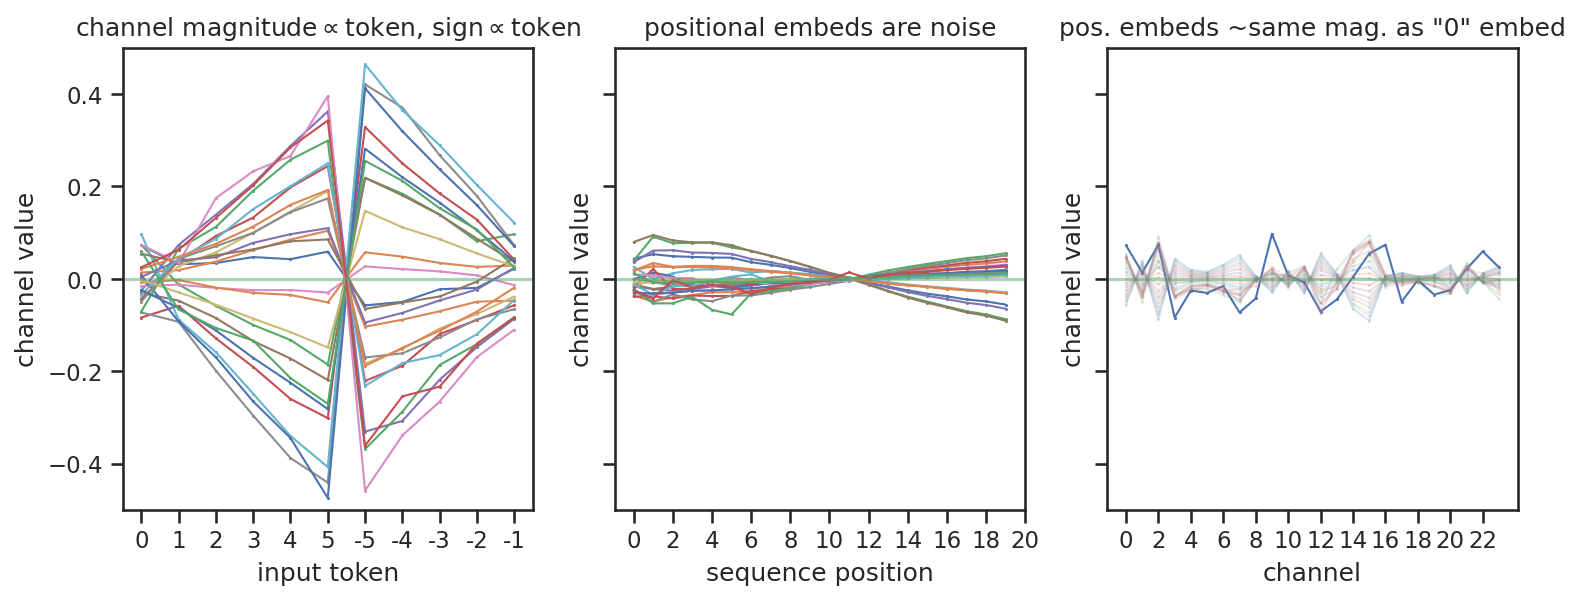

In [4]:
print('embed channels encoding +5 positively:', where(m.embeds[5] >= 0))
print('embed channels encoding +5 negatively:', where(m.embeds[5] < 0))
print('positional embeddings average to zero per position:', m.pos_embeds.mean(axis=1))

rowplot([
    [lambda: listplot(m.embeds.T, line=True, ylim=[-0.5,0.5], h=0, 
                      title='channel magnitude$\propto$token, sign$\propto$token', xlabel='input token', ylabel='channel value'),
     lambda: plt.xticks(np.arange(0, m.n_vocab, 1), m.embed_labels)],

    [lambda: listplot(m.pos_embeds.T, line=True, h=0, 
                      title='positional embeds are noise', xlabel='sequence position', ylabel='channel value'),
     lambda: plt.xticks(np.arange(0, m.seq_len+1, 2))],

    [lambda: listplot([m.embeds[0]], line=True, 
                      title='pos. embeds ~same mag. as "0" embed', xlabel='channel', ylabel='channel value'),
     lambda: listplot(m.pos_embeds, line=True, alpha=0.2, h=0),
     lambda: plt.xticks(np.arange(0, m.d_embd, 2))]
], sharey=True);

So, the sign and magnitude of each input token is directly preserved in the embeddings.

# 2. Attention softmax equally attends to each token<a class="anchor" id="softmax"></a>

We demonstrate this by showing the attention pattern matrix and working backward.

- Note the values are equal across each row, i.e. row $r$ attends to each with weight $1/r$.


In [130]:
m.attn_pattern[:10,:10]

array([[1.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.50000846, 0.49999157, 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.3333323 , 0.3333379 , 0.3333298 , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.25000635, 0.24999359, 0.2500129 , 0.24998713, 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.20000176, 0.19999845, 0.20000356, 0.19999674, 0.19999944, 0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.1666682 , 0.16666543, 0.16666973, 0.166664  , 0.16666627, 0.16666628, 0.        , 0.        , 0.        , 0.        ],
       [0.1428585 , 0.14285609, 0.14285986, 0.14285485, 0.14285684, 0.14285684, 0.14285694, 0.        , 0.        , 0.        ],
       [0.1250012 , 0.12499913, 0.12500235, 0.12499806, 0.12499976, 0.12499976, 0.12499985, 0.124

This is achieved by the attention projections having very small weights without outliers. The input stream is also bounded by the original embeddings and doesn't contain outliers.
- So, we get a situation where small_number * sum(small_numbers * small_numbers) ~= 0.
- To apply the softmax to the results, we exponentiate them: e^(small_number) ~= 1.
- And since every exponentiation has the same value 1, the softmax evenly attends to each token, with a weight $1/\text{ntokens}$ .

In [131]:
# quick demo using the existing model showing every pre-softmax is near-zero before the softmax.
# notice that the same token (in the index) has ~same exponentiation. They are slightly different only due to the positional embedding

pd.DataFrame(m.attn_q @ m.attn_k.T, index=m.toks_in)  # Columns are prior-sequence position, rows are the current token (will mask out the upper-right triangle)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
-1,-0.00001414,-0.00001397,-0.00001136,-0.00001436,-0.00002410,-0.00002377,-0.00002157,-0.00002015,-0.00001870,-0.00001701,-0.00001546,-0.00001412,-0.00001226,-0.00001034,-0.00000860,0.00000363,0.00000495,0.00000635,-0.00000350,-0.00000206
1,0.00004465,-0.00007227,0.00010617,-0.00013217,-0.00002601,-0.00002603,-0.00002412,-0.00002137,-0.00001999,-0.00001806,-0.00001659,-0.00001522,-0.00001255,-0.00001035,-0.00000808,-0.00028473,-0.00028324,-0.00028144,-0.00000201,-0.00000031
-2,-0.00004314,0.00001479,-0.00006934,0.00004376,-0.00002316,-0.00002265,-0.00002031,-0.00001955,-0.00001806,-0.00001649,-0.00001490,-0.00001358,-0.00001212,-0.00001034,-0.00000886,0.00014589,0.00014712,0.00014832,-0.00000424,-0.00000292
2,0.00007441,-0.00010179,0.00016567,-0.00019182,-0.00002698,-0.00002718,-0.00002542,-0.00002200,-0.00002064,-0.00001859,-0.00001717,-0.00001579,-0.00001271,-0.00001036,-0.00000782,-0.00043074,-0.00042915,-0.00042715,-0.00000126,0.00000057
0,0.00001460,-0.00004248,0.00004610,-0.00007196,-0.00002504,-0.00002488,-0.00002282,-0.00002075,-0.00001933,-0.00001753,-0.00001602,-0.00001466,-0.00001241,-0.00001035,-0.00000835,-0.00013736,-0.00013595,-0.00013435,-0.00000277,-0.00000120
0,0.00001482,-0.00004269,0.00004654,-0.00007240,-0.00002505,-0.00002489,-0.00002283,-0.00002076,-0.00001934,-0.00001753,-0.00001602,-0.00001467,-0.00001241,-0.00001035,-0.00000835,-0.00013843,-0.00013703,-0.00013543,-0.00000277,-0.00000120
0,0.00001536,-0.00004323,0.00004762,-0.00007349,-0.00002507,-0.00002491,-0.00002286,-0.00002077,-0.00001935,-0.00001754,-0.00001603,-0.00001468,-0.00001241,-0.00001035,-0.00000835,-0.00014109,-0.00013968,-0.00013808,-0.00000275,-0.00000118
0,0.00001496,-0.00004284,0.00004681,-0.00007268,-0.00002506,-0.00002490,-0.00002284,-0.00002077,-0.00001934,-0.00001753,-0.00001603,-0.00001467,-0.00001241,-0.00001035,-0.00000835,-0.00013912,-0.00013771,-0.00013612,-0.00000277,-0.00000119
0,0.00001526,-0.00004313,0.00004741,-0.00007328,-0.00002507,-0.00002491,-0.00002286,-0.00002077,-0.00001935,-0.00001754,-0.00001603,-0.00001468,-0.00001241,-0.00001035,-0.00000835,-0.00014059,-0.00013918,-0.00013758,-0.00000276,-0.00000119
0,0.00001543,-0.00004331,0.00004776,-0.00007363,-0.00002508,-0.00002492,-0.00002287,-0.00002078,-0.00001936,-0.00001755,-0.00001604,-0.00001468,-0.00001242,-0.00001035,-0.00000835,-0.00014143,-0.00014002,-0.00013842,-0.00000275,-0.00000118


There are only eleven tokens and a max of 20 positions. So, we can computationally verify for each (token embed + positional embed) that the result is nearly one.

In [132]:
# Attempt every possible embed + positional embedding that could go into the softmax
# If they are all nearby 0, the softmax will divide them all equally resulting in ~1/ntokens
# (Notice above that the same token has ~same value pre-softmax -- different only due to the positional embedding!)
# So we wonder: How far is the farthest from 0? (e^0 == 1)
max_dist = 0.0
for embed in m.embeds:
    for pos_embed in m.pos_embeds:
        stream_in = embed + pos_embed
        attn_q = stream_in @ m.attn_wq + m.attn_bq    # q projection -- (toks,24) @ (24,12) => (toks,12)
        attn_k = stream_in @ m.attn_wk + m.attn_bk    # k projection -- (toks,24) @ (24,12) => (toks,12)
        
        # how close q projection matches k projection -- all ~0
        # next we would normally apply a mask then exponentiate for softmask!
        matches = attn_q @ attn_k.T / np.sqrt(m.d_head)   # 
        max_dist = max(max_dist, abs(matches))            # find farthest dist from 0

print('largest distance from 0:', max_dist)

largest distance from 0: 0.0002568125641409073


Therefore, we have proven that for every possible input, the attention attends equally to each prior token. Again, this is primarily because there are no outlier input embeddings or weights, and the projection matrices are entirely nearly zero.

# 3. Equally-divided attention computes the cumulative mean<a class="anchor" id="mean"></a>

We've shown that the attention block equally attends to each prior input.

**Conceptually:**
- In this special case, we claim that each channel output can be rewritten as a linear combination of the prior-input means $\bar{x}_{\leq t}$.

- This stems from two things:
    1. It is well-known that two linear projections can be rewritten as a single linear projection*. For example, this is why neural nets require non-linear activations.
    2. The mean _is_ summing all previous elements, each divided by the number of elements (i.e. equally attending to them).

**More formally, we claim:**
> Given token index $t$, output channel position $p$, and input mean $\bar{x}_{\leq t}$, the attention output $a$ is given by:
> 
> $$ a_{t,p} = \mathbf{\overline{x}_{\leq t}} \cdot \mathbf{c_p} + b_p,$$
> 
> for a $k$-dimensional embedding and $k\text{x}k$ coefficients $\mathbf{C}$ (with biases $\mathbf{b}$ and row $\mathbf{c_p}$).

> Given an $h$-dimensional head, these are computed from the $k\text{x}h$ value projection weights $\mathbf{V}$ (with $1\text{x}h$ biases $\mathbf{b_v}$) and $h\text{x}k$ output projection weights $\mathbf{O}$ (with $1\text{x}k$ biases $\mathbf{b_o}$) as follows*:
>
> $$
\begin{align}
\mathbf{C} = && (\mathbf{V}\mathbf{O})^T\\
\mathbf{b} = && \mathbf{b_v}\mathbf{O} + \mathbf{b_o}
\end{align}
$$

\* For a derivation of these values (i.e. how to combine two linear projections into one), see the [APPENDIX](#proof).


Let's first show visually that the attention outputs are directly related to the input token means:

input tokens: [ 1  2  3  0  0  0  0 -5 -1 -2 -3  0  0  0  0  5  5  5  0  0]
input token cumulative mean: [ 1.          1.5         2.          1.5         1.2         1.          0.85714286  0.125       0.         -0.2        -0.45454545
 -0.41666667 -0.38461538 -0.35714286 -0.33333333  0.          0.29411765  0.55555556  0.52631579  0.5       ]


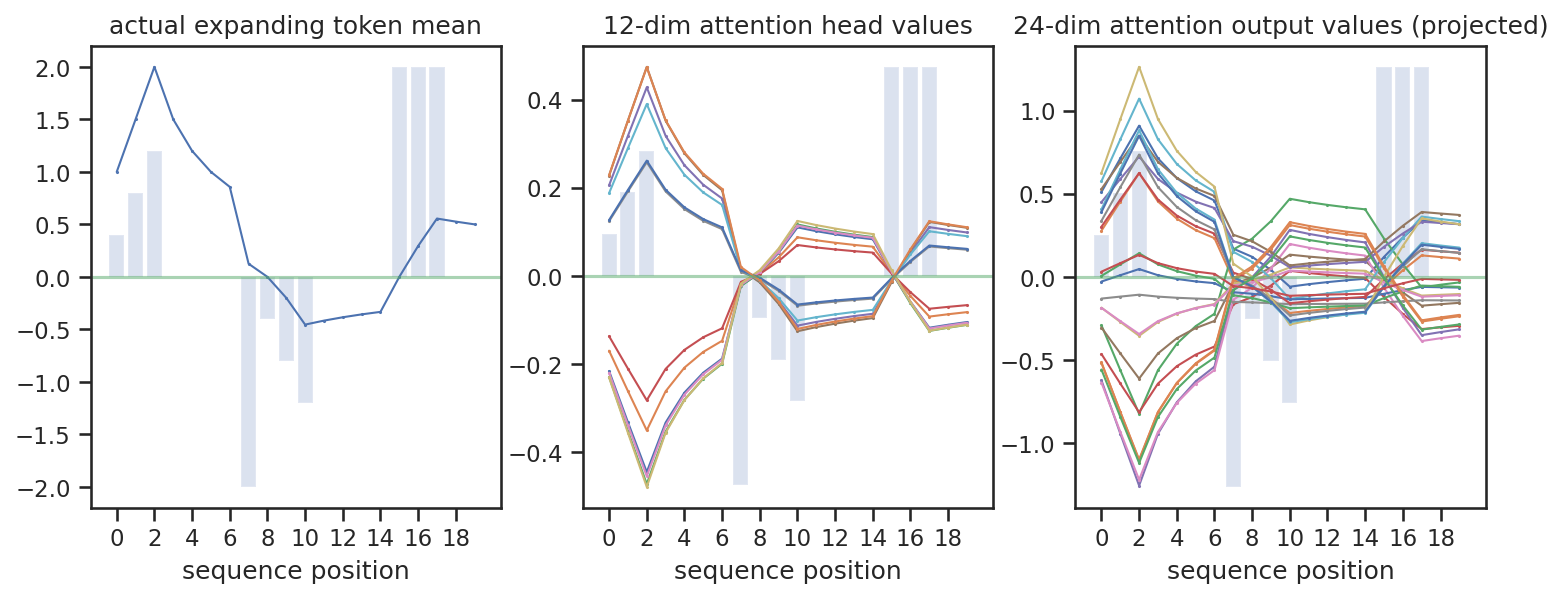

In [7]:
# Play around with the input values to better understand the expanding mean!
# Do you see that each of the 24-dim outputs are a linearly transformed rolling mean?
# The sharply-decr slope is a property of the mean, since we divide by 2 then 3 then 4 ... (yielding x*0.5, x*0.3, x*0.25)

#               0  1  2  3  4  5  6   7   8   9  10 11 12 13 14 15 16 17 18 19
m.run(np.array([1, 2, 3, 0, 0, 0, 0, -5, -1, -2, -3, 0, 0, 0, 0, 5, 5, 5, 0, 0]) + m.max_value) # +max_value needed for compatibility w/ Dataset

expanding_token_mean = np.cumsum(m.toks_in) / np.arange(1,m.n_toks_in+1)
print('input tokens:', m.toks_in);
print('input token cumulative mean:', expanding_token_mean);

rowplot([
    [lambda: listplot(expanding_token_mean, line=True, h=0,
                      title='actual expanding token mean', xlabel='sequence position'),
     lambda: plt.xticks(np.arange(0, m.seq_len, 2)),
     lambda: plt.bar(range(len(m.toks_in)), np.max(expanding_token_mean)*m.toks_in/m.max_value, alpha=0.2)],

    [lambda: listplot(m.attn.T, line=True, h=0, 
                      title='12-dim attention head values', xlabel='sequence position'),
     lambda: plt.xticks(np.arange(0, m.seq_len, 2)),
     lambda: plt.bar(range(len(m.toks_in)), np.max(m.attn.T)*m.toks_in/m.max_value, alpha=0.2)],

    [lambda: listplot(m.attn_out.T, line=True, h=0, 
                      title='24-dim attention output values (projected)', xlabel='sequence position'),
     lambda: plt.xticks(np.arange(0, m.seq_len, 2)),
     lambda: plt.bar(range(len(m.toks_in)), np.max(m.attn_out.T)*m.toks_in/m.max_value, alpha=0.2)],
]);

### "Elementary" derivation of how the attention block computes the mean

It's useful to understand how the attention sub-block computes the mean.

In the [APPENDIX](#proof), we derive $\mathbf{C}$ and $\mathbf{b}$ below by assuming we are given only the first token in a sequence (token $1$). This allows us to combine two projections into one and directly compute the attention output $a$ for a given channel position $p$:

$$ a_{1,p} = \mathbf{x_{1}} \cdot \mathbf{c_p} + b_p.$$

However, this assumes there is only a single input token to attend to! If we add a second token, we must take into account the softmax values $s_1$ and $s_2$ which weight the attention as so:

$$ a_{2,p} = s_1 \cdot (\mathbf{x_{1}} \cdot \mathbf{c_p} + b_p) + s_2 \cdot (\mathbf{x_{2}} \cdot \mathbf{c_p} + b_p).$$

But if _all_ softmax values are $1/t$, then each term is equally weighted and the mean becomes apparent:

$$
\begin{align}
a_{2,p} = && (\mathbf{x_{1}} \cdot \mathbf{c_p} + b_p)/2 + (\mathbf{x_{2}} \cdot \mathbf{c_p} + b_p)/2\\
        = && (\mathbf{x_{1}}/2 + \mathbf{x_{2}}/2) \cdot \mathbf{c_p} + (b_p/2 + b_p/2)\\
        = && \mathbf{\overline{x}_{\leq 2}} \cdot \mathbf{c_p} + b_p.
\end{align}
$$

Generalizing this (left to the reader), we thereby obtain the original proposition:

$$a_{t,p} = \mathbf{\overline{x}_{\leq t}} \cdot \mathbf{c_p} + b_p.$$

Alternatively in matrix form, we can compute the complete attention output $\mathbf{A}$:

$$\mathbf{A} = \mathbf{\overline{X}_{\leq}}\mathbf{C^T} + \mathbf{b}.$$

> In other words: the entire attention block can be reduced to a single linear projection with respect to the mean of the prior tokens!

Let's demonstrate using these exact examples below:

In [18]:
# EXAMPLE applying the linear model manually (C = mha_coefs, b = mha_biases)
m.run(np.array([-3, -4, -5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 5, 5, 3, 0, 0]) + m.max_value)
print(m.toks_in)

# Compute C and b
mha_coefs = (m.attn_wv @ m.attn_wo).T             # rows=output pos (as a func of input pos)  (toks,toks) 
mha_biases = m.attn_bv @ m.attn_wo + m.attn_bo    # (d_embd,)

out_pos = 10
print('first tok, pos 0 (actual):', m.attn_out[0,out_pos])
print('                 (linear):', np.dot(m.attn_in[0], mha_coefs[out_pos]) + mha_biases[out_pos])
print('second tok, pos 1 (actual):', m.attn_out[1,out_pos])
print('                  (linear):', 0.5*np.dot(m.attn_in[0], mha_coefs[out_pos]) + 0.5*np.dot(m.attn_in[1], mha_coefs[out_pos]) + mha_biases[out_pos])


# *** For an arbitrary token and output position
tok = 8; out_pos = 5
out_val = np.dot(np.mean(m.attn_in[:tok+1], axis=0), mha_coefs[out_pos]) + mha_biases[out_pos]  # o_t,p = \bar{x_<=t} . c_p + b_p
print(f'tok {tok:2}, pos {out_pos:2} (actual):', m.attn_out[tok,out_pos])
print(f'               (linear):', out_val)

[-3 -4 -5  0  0  0  0  0  0  0  0  0  0  1  2  5  5  3  0  0]
first tok, pos 0 (actual): -0.32659882
                 (linear): -0.32659882
second tok, pos 1 (actual): -0.36305144
                  (linear): -0.3630519062280655
tok  8, pos  5 (actual): 0.40263212
               (linear): 0.40262118


In [9]:
# EXAMPLE matrix form
embed_means = np.cumsum(m.attn_in, axis=0) / np.arange(1,m.n_toks_in+1).reshape(-1,1)
attn_out = embed_means @ m.mha_coefs.T + m.mha_biases

assert np.all(np.isclose(attn_out, m.attn_out, atol=1e-3))  # Should see no output if all positions match!

# 4. Feed-forward network "cleans up" the signal<a class="anchor" id="ffn"></a>

The MLP matches two unembed patterns outputted by the attention sub-block -- positive and negative. The zero pattern matches ~half of the positive pattern and ~half of the negative pattern.

We will next show that the MLP output for hidden neuron $i$ is ~identical to the input pattern it matches!

In [10]:
# Each of the eight hidden neurons match the sign 22 to 23 of their 24 inputs!

print(f'For each of the {m.d_mlp} hidden neurons, # channels w/ same-sign input and output (of {m.d_embd}):')
print(np.sum(np.sign(m.mlp_win.T) == np.sign(m.mlp_wout), axis=1))

For each of the 8 hidden neurons, # channels w/ same-sign input and output (of 24):
[22 22 23 22 22 22 22 23]


This becomes more obvious when we examine the MLP weights to see what patterns it is detecting and outputting.

Recall that the RELU zeros out negative hidden outputs. So if a pattern does NOT match, the wrong pattern will NOT be outputted to the stream!

It is especially interesting to notice there are exactly two patterns explicitly put on the stream and detected (corresponding to positive and negative). These patterns are stored as the sign of each channel, and they are remarkably consistent between the MHA output, MLP input/output, and unembeddings.

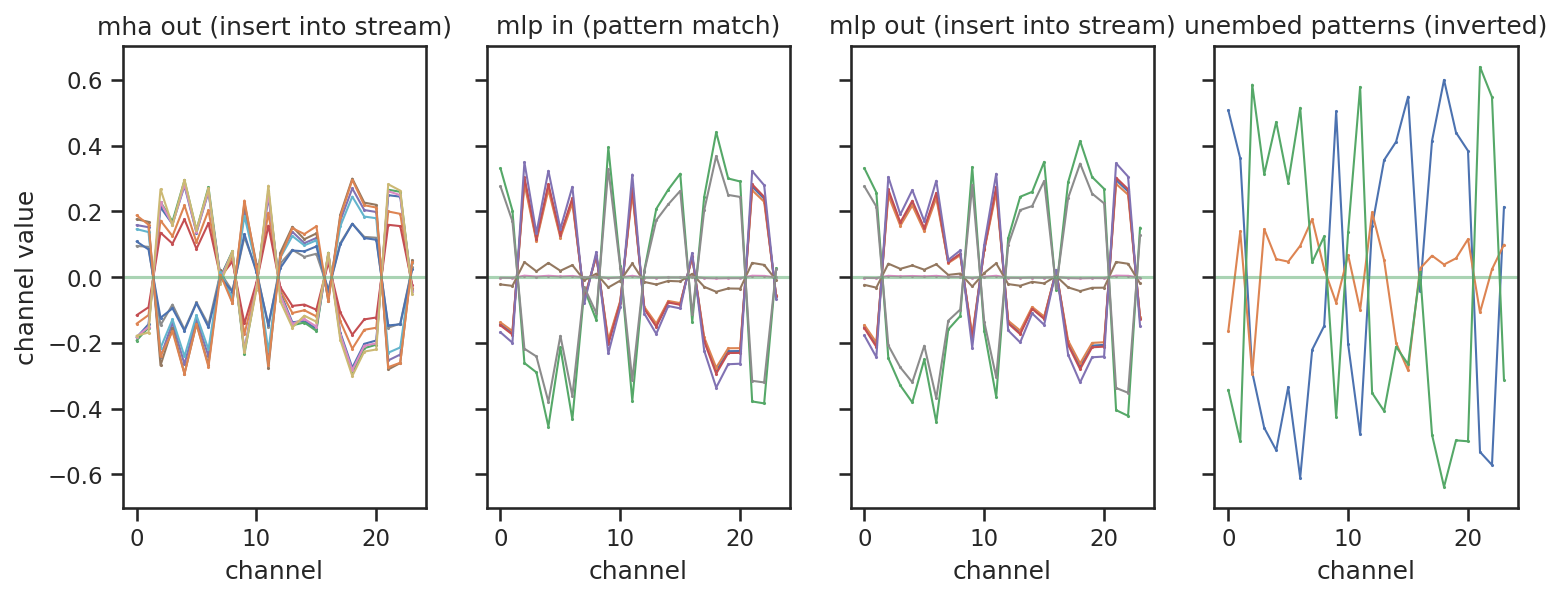

In [16]:
# INVESTIGATE MLP
# - The output pattern matches the input pattern nearly exactly (i.e. the same channels are elevated)
# - However, the RELU "corrects" the pattern if it mostly matches (i.e. a few wrong-sign positions)
# - It does this by NOT outputting patterns it doesn't match.

# Note these are WEIGHTS, so the exact input doesn't matter
neg = np.array([0,1,3,4,5,6])
pos = np.array([2,7])
rowplot([
    [lambda: listplot(m.attn_wo, line=True, h=0, xlabel='channel', ylabel='channel value', title='mha out (insert into stream)')],
    [lambda: listplot(m.mlp_win.T, line=True, h=0, xlabel='channel', title='mlp in (pattern match)')],
    [lambda: listplot(m.mlp_wout, line=True, h=0, xlabel='channel', title='mlp out (insert into stream)')],
    [lambda: listplot(-m.unembed_w.T, line=True, h=0, xlabel='channel', title='unembed patterns (inverted)')],
], sharey=True);

Because the input/output signs match nearly exactly, the ffn **error-corrects** and **boosts** the input signal.

We can see directly that its output largely overwrites much of the residual stream, pushing values away from the boundary:

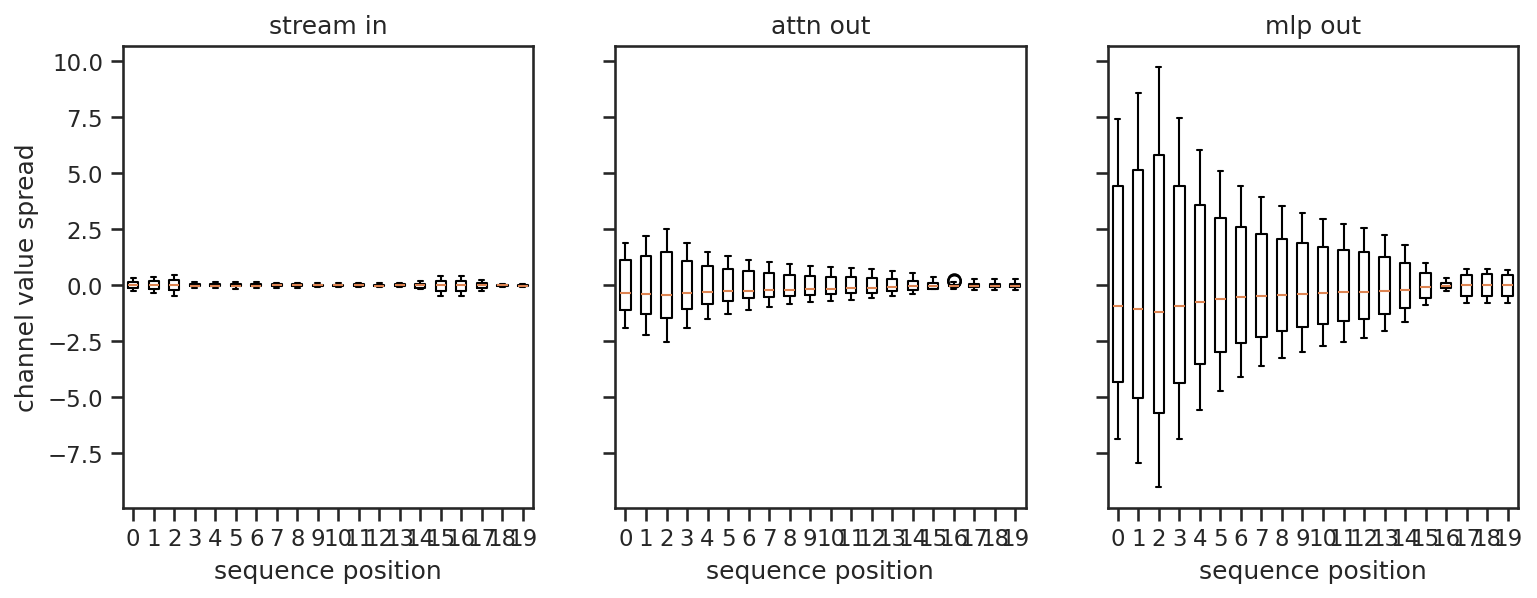

In [25]:
# Recall that the per-channel magnitude is the MEAN of the prior inputs
rowplot([
    [lambda: plt.boxplot(m.stream_in.T, labels=range(len(m.mlp_out))), 
     lambda: plt.title('stream in'), lambda: plt.xlabel('sequence position'), lambda: plt.ylabel('channel value spread')],
    [lambda: plt.boxplot(m.attn_out.T, labels=range(len(m.mlp_out))), 
     lambda: plt.title('attn out'), lambda: plt.xlabel('sequence position')],
    [lambda: plt.boxplot(m.mlp_out.T, labels=range(len(m.mlp_out))),
     lambda: plt.title('mlp out'), lambda: plt.xlabel('sequence position')],
], sharey=True);

# 5. What about the zero unembed pattern?<a class="anchor" id="unembed"></a>

In the above graphs, the zero pattern is not outputted by MHA or detected/outputted by MLP. So, how can the zero pattern possibly be detected by the unembed?

It turns out that the "zero" pattern is encoded in the biases. This is analogous to how the "reference pattern" in logistic regression is encoded in the bias.

By plotting the "token 1" biases as computed in section 3 for the MHA and MLP (excluding RELU), we see they nearly-exactly encode the "zero" unembed pattern:

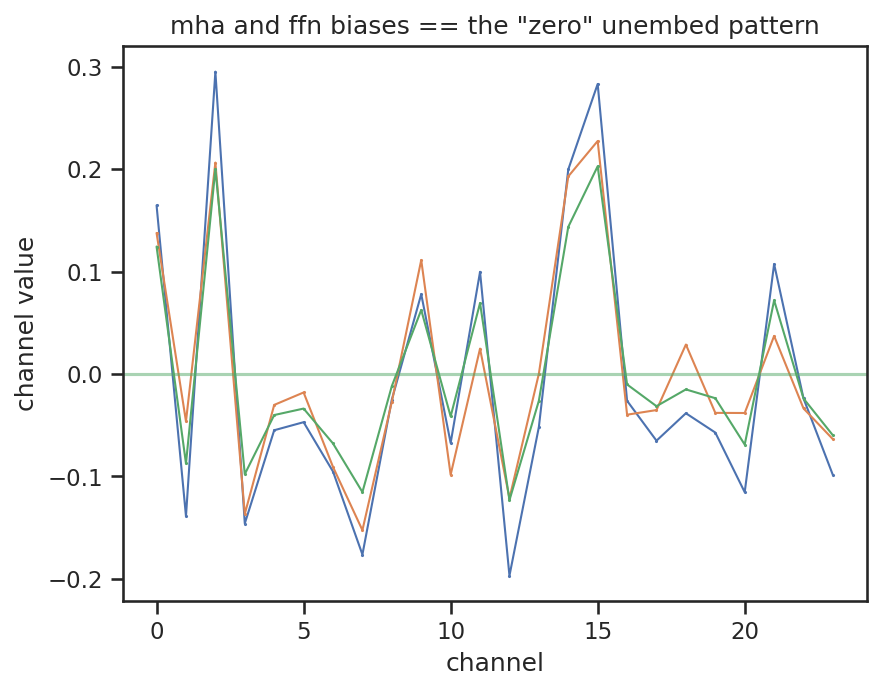

In [27]:
# The MHA and MLP biases, as calculated in section 3, match the zero pattern
listplot([m.unembed_w[:,1], m.mha_biases, m.ffn_biases], line=True, h=0, 
         title='mha and ffn biases == the "zero" unembed pattern', xlabel='channel', ylabel='channel value')

However, for these biases to have a large impact, they must be accompanied by low-magnitude channel values.

For this to occur, the zero pattern signs ~half-match the positive and negative unembed pattern signs:

In [214]:
sunembed = np.sign(m.unembed_w).astype(int).T

print(f'# same-sign "zero" and "neg" (of {m.d_embd}):', np.sum(sunembed[1] == sunembed[0]))  # of 24
print(f'# same-sign "zero" and "pos" (of {m.d_embd}):', np.sum(sunembed[1] == sunembed[2]))  # of 24
print(f'# same-sign "pos" and "neg"  (of {m.d_embd}):', np.sum(sunembed[0] == sunembed[2]))  # of 24

# same-sign "zero" and "neg" (of 24): 11
# same-sign "zero" and "pos" (of 24): 13
# same-sign "pos" and "neg"  (of 24): 0


In the MLP, the zero pattern is neither directly matched nor outputted. However, a low-magnitude residual stream affected by the MHA biases (shown above) will match the positive and negative patterns weakly.

The pattern matching occurs due to the dot product:
- If the input signs match the weight signs, we obtain a large positive hidden neuron value.
- In the opposite case, we obtain a large negative hidden neuron value.
- As the input magnitude increases, the hidden neuron magnitudes also increase.
- If the input magnitudes are small, the hidden neuron magnitudes will also be small (but their sign will still indicate pattern match).

In the following, we observe the eight MLP neurons. Notice the "zero" labels all ~equally activate the neurons, while the "low positives" only activate _some_ of them:

In [28]:
# Notice the "zero" labels (starred) all ~equally activate the neurons, while the "positive" labels only activate some of them (others near zero/negative):
# - Recall that there are a ~equal number of opposite patterns, so this will bring the weights closeby zero.

m.run(np.array([5, -5, 3, 2, -5, -2, -1, 4, 5, 5, 5, 5, 5, 5, 5, 5]) + m.max_value)
print('  input tokens:', m.toks_in)
print('cumulative sum:', np.cumsum(m.toks_in))
print(' output labels:', m.labels)

print(); print('output label | MLP input sign | MLP hidden neuron values')
for i in range(m.n_toks_in):
    print('*' if m.labels[i] == 1 else ' ', end='')
    print(m.labels[i], np.sign(m.attn_out[i]).astype(int), m.hidden[i])


  input tokens: [ 5 -5  3  2 -5 -2 -1  4  5  5  5  5  5  5  5  5]
cumulative sum: [ 5  0  3  5  0 -2 -3  1  6 11 16 21 26 31 36 41]
 output labels: [2 1 2 2 1 0 0 2 2 2 2 2 2 2 2 2]

output label | MLP input sign | MLP hidden neuron values
 2 [ 1  1 -1 -1 -1 -1 -1 -1 -1  1  1 -1  1  1  1  1 -1  1  1  1  1 -1 -1  1] [ -8.71235     -8.375496    14.529226    -8.930467   -10.2197075   -1.3556988   -0.12924725  12.124514  ]
*1 [ 1 -1  1 -1 -1 -1 -1 -1 -1  1 -1  1 -1 -1  1  1 -1 -1 -1 -1 -1  1 -1 -1] [0.29371414 0.28247762 0.4900266  0.30153626 0.3439835  0.04571045 0.00463238 0.40809906]
 2 [ 1  1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1  1  1  1  1 -1  1  1  1  1 -1 -1  1] [-1.486733   -1.4294275   3.2634277  -1.5237269  -1.7438643  -0.23114383 -0.02200314  2.7233865 ]
 2 [ 1  1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1  1  1  1  1 -1  1  1  1  1 -1 -1  1] [-1.9517646  -1.8764291   3.988881   -2.0003762  -2.2894022  -0.30357832 -0.02887579  3.3286674 ]
*1 [ 1 -1  1 -1 -1 -1 -1 -1 -1  1 -1  1 -1 -1  1  1 -1 -1  1

In [42]:
# If we equally weight the outputs as a low-magnitude input would, we effectively zero out our weights
# This allows the bias to inch it toward the desired "zero" pattern's signs:
print('mean per-channel weights:', m.mlp_wout.mean(axis=0))
print('bias:', m.mlp_bout)

mean per-channel weights: [-0.00605019 -0.05313775  0.08372439  0.0123035   0.03481946  0.02095986  0.03404465 -0.01251634  0.01026748 -0.02236199  0.00795271
  0.06136047 -0.04760577 -0.03563061  0.00838158  0.01317514  0.00106885 -0.04273967 -0.05295373 -0.0429178  -0.05001276  0.06695439
  0.04433465 -0.03342056]
bias: [ 0.07362018 -0.05094207  0.11443717 -0.05684377 -0.02475116 -0.02076853 -0.04047872 -0.06660617 -0.00608693  0.03648141 -0.02414637
  0.03987577 -0.07000588 -0.01482397  0.08340748  0.11837593 -0.00453076 -0.01706066 -0.0075587  -0.01191136 -0.03955231  0.04105154
 -0.0161934  -0.03498874]


# 6. Designing a 38-weight attention-only cumsum circuit<a class="anchor" id="newnet"></a>

> **NOTE:** If you'd like to challenge your understanding of the above, stop reading and manually implement a minimal circuit that implements the problem statement!

Utilizing the principles above, we can construct a 38-weight* attention-only circuit that implements the problem statement.

- We choose only two embed dimensions and a single head neuron.
- Only attention is used, no MLP.
- We retain the 20-token sequence length and tokens from -5 to 5 inclusive.

\* Since positional embeddings, KQV-projection biases, and unembedding biases are zeroed out, they are not counted toward the weight total.

First, let's examine our minimal model's performance relative to the trained model:

In [9]:
N = 1000
dataset = CumsumDataset(size=1000, max_value=5, seq_len=20, seed=np.random.randint(100000)).to(device); fix_dataset(dataset)
m2 = CumsumModel()  # loads attention-only circuit

# Actual vs independent implementations - should see identical numbers
print('Original model:')
test_actual(model, dataset); print()

print('Minimal attention-only model:');
test_impl(m2, dataset)

m2.unembed_w

Original model:
Average cross entropy loss: 0.077
Mean probability on correct label: 0.935
Median probability on correct label: 0.999
Min probability on correct label: 0.551

Minimal attention-only model:
Average cross entropy loss: 0.027
Mean probability on correct label: 0.976
Median probability on correct label: 1.000
Min probability on correct label: 0.705
Incorrect labels: 0


array([[-10.,   1.,  10.],
       [ 10.,   1., -10.]])

This arguably performs even better than the original! Yet, I challenge the reader to improve the current model, since it has not been optimized.


In [11]:
# Try a particular example
m2.run(np.array([ 1, 0, 0, 0, 0, 0, 0, -1, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0]) + m2.max_value)
print('input tokens:', m2.toks_in)
print('  out labels:', m2.labels); print()
print('class probabilities:\n', m2.probs)

input tokens: [ 1  0  0  0  0  0  0 -1  0  0  0  0  0  0  0  5  0  0  0  0]
  out labels: [2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 2 2 2 2 2]

class probabilities:
 [[0.         0.         1.        ]
 [0.         0.         1.        ]
 [0.         0.         1.        ]
 [0.         0.         1.        ]
 [0.         0.00000002 0.99999998]
 [0.         0.00000043 0.99999957]
 [0.         0.00000462 0.99999538]
 [0.12953422 0.78363639 0.08682939]
 [0.10650698 0.78698604 0.10650698]
 [0.10650698 0.78698604 0.10650698]
 [0.10650698 0.78698604 0.10650698]
 [0.10650698 0.78698604 0.10650698]
 [0.10650698 0.78698604 0.10650698]
 [0.10650698 0.78698604 0.10650698]
 [0.10650698 0.78698604 0.10650698]
 [0.         0.         1.        ]
 [0.         0.         1.        ]
 [0.         0.         1.        ]
 [0.         0.         1.        ]
 [0.         0.         1.        ]]


#### Overall design notes
- We arbitrarily set the embeds to 1/100 of the original token integers. This ensures perfect linearity, sign, and magnitude -- zero noise.
    - The embeds were scaled down to ensure numerical stability of the final log softmax.
    - The first dimension is the original sign, the second the opposite sign.
- The positional embeddings are set to zero.
- As we showed earlier, making the K and Q projections have near-zero weights ensures the attention output is a linear combination of the input mean.
- Two embeddings are required to ensure zero detection.
    - For the unembeddings, we choose +1/-1 => positive, -1/+1 => negative, +1/+1 => zero.
    - Normally, we make the two dimensions opposites. 
    - However, if the values are close to zero, the biases become pronounced, pushing both dimensions positive.
    - Therefore, we choose slightly positive biases for the output projection biases and unembedding bias.

Now, let's choose the weights. Most essential is to place margins on the "zero" class so it has no risk of improper classification.

---
#### Choosing the V and O projections

We decided above that embedding dimensions are opposite sign, so the mean's dimensions also have opposite sign, i.e. $\overline{x}_{\leq t,1} = -\overline{x}_{\leq t,2}$.

So, to compute the $\mathbf{V} = (x, y)^T$ and $\mathbf{O} = (z, w)$ projections, we multiply out the attention output $\mathbf{A} = \mathbf{\overline{X}_{\leq}}\mathbf{C^T} + \mathbf{b}$ into two channels:

$$
\begin{align}
\left\{
\begin{array}{ll}
o_1 = && \overline{x}_{\leq t,1}(xz) + \overline{x}_{\leq t,2}(yz) + b_vz + b_{o,1}\\
o_2 = && \overline{x}_{\leq t,1}(xw) + \overline{x}_{\leq t,2}(yw) + b_vw + b_{o,2}\\
\end{array}
\right\}

\implies
\left\{
\begin{array}{ll}
o_1 = && \overline{x}_{\leq t} \cdot z(x - y) + b_vz + b_{o,1}\\
o_2 = && \overline{x}_{\leq t} \cdot z(x - y) + b_vw + b_{o,2}
\end{array}
\right\}
\end{align}
$$

+ For simplicity, let's set $\mathbf{V} = (x,y)^T = (1,0)^T$. This allows us to scale each dimension independently using $z$ and $w$.
+ We already assumed that the KQV biases are zero, so $b_v = 0$.
+ Recall that we must give the two dimensions opposite sign, so we'll also set $z = -w$.

This leaves us with:

$$
\begin{align}
\left\{
\begin{array}{ll}
o_1 = &&  z \cdot \overline{x}_{\leq t} + b_{o,1}\\
o_2 = && -z \cdot \overline{x}_{\leq t} + b_{o,2}
\end{array}
\right\}
\end{align}
$$

----
#### Making the "zero" class logit a constant
The idea is we want to set the "zero" class logit to a fixed number, regardless of the input embedding. Then we can ensure the pos/neg classes never go below it.

To do this, we express the "zero" logit in terms of the two dimensions. To compute this final logit, we sum the attention output with the current token embedding $\mathbf{e}$, then multiply by the unembeddings $\mathbf{u_{\textbf{zero}}}$. 
+ For the final step, recall that our "zero" pattern is two positive signs. So we must let $u_{\textbf{zero},1} = u_{\textbf{zero},2}$, which happens to cancel out the input embedding (since $e_1 = -e_2$ by design).

$$
\begin{align}
l_{\textbf{zero}} = && u_{\textbf{zero},1} \cdot o_1 + u_{\textbf{zero},2} \cdot o_2 + b_u\\
                  = && u_{\textbf{zero},1}\left(\overline{x}_{\leq t} \cdot z + b_{o,1} + e_1\right) + u_{\textbf{zero},2}\left(-\overline{x}_{\leq t} \cdot z + b_{o,2} + e_2\right) + b_u\\
                  = && z \cdot \overline{x}_{\leq t}\left(u_{\textbf{zero},1} - u_{\textbf{zero},2}\right) + (e_1 + b_{o,1}) \cdot u_{\textbf{zero},1} + (e_2 + b_{o,2}) \cdot u_{\textbf{zero},2} + b_u\\
                  = && (b_{o,1} + b_{o,2}) \cdot u_{\textbf{zero},1} + b_u.
\end{align}
$$

Hence when the mean is zero, our "zero" class logit will be fixed based on our constants!


----
> **Next, we must bound our "zero" logit threshold above and below, to ensure it has proper margins from the pos/neg classes.**

----
#### Lower bound. Ensuring a zero mean yields the "zero" class

We must ensure that when the mean is zero, $l_{\textbf{zero}} > \max{(l_{\textbf{pos}}, l_{\textbf{neg}})}$. Ideally we would also make it as large as possible to obtain the largest probability disparity. We'll assume the negative unembeddings are the exact opposite of the positive ones to simplify the analysis, i.e. $u_{\textbf{pos}} = -u_{\textbf{neg}}$.

For the "pos" class, our unembed pattern requires $u_{\textbf{pos},1} > 0$ and $u_{\textbf{pos},2} < 0$. For simplicity, let's suppose $u_{\textbf{pos},1} = -u_{\textbf{pos},2}$ and $b_{o1} = b_{o2}$. Then we can directly compute the logit $l$:

$$
\begin{align}
l_{\textbf{pos}} = && z \cdot \overline{x}_{\leq t}\left(u_{\textbf{pos},1} - u_{\textbf{pos},2}\right) + (e_1 + b_{o1}) \cdot u_{\textbf{pos},1} + (e_2 + b_{o2}) \cdot u_{\textbf{pos},2} + b_u\\
                 = && 2 \cdot (z \cdot \overline{x}_{\leq t} + e_1) \cdot u_{\textbf{pos},1} + b_u.\\
\end{align}
$$

Now let's find the set point for the remaining constants when $\overline{x}_{\leq t} = 0$. Based on our embedding scheme above $\mathbf{e_{\text{token}}} = (\text{token} / 100, -\text{token} / 100)$, the largest logit will be obtained by the largest embedding, +5/-5. So, we will assume the input embedding $\mathbf{e} = (5/100, -5/100)$:

$$
\begin{align}
l_{\textbf{zero}} > l_{\textbf{pos}} \\
\implies && 2 \cdot b_{o1} \cdot u_{\textbf{zero},1} + b_u > && 2 \cdot (z \cdot \overline{x}_{\leq t} + e_1) \cdot u_{\textbf{pos},1} + b_u\\
\implies && b_{o1} \cdot u_{\textbf{zero},1} > && 5/100 \cdot u_{\textbf{pos},1}.
\end{align}
$$

----
#### Upper bound. Ensuring the smallest mean is above the "zero" logit threshold

We are also constrained in the opposite direction -- the _smallest_ mean must not be classified as zero.

The smallest mean is given by the smallest embed (+1/-1) over the sequence length (20), in this case $\overline{x}_{\leq t} = (1/100) / 20 = 1/2000$. To achieve the "smallest upper bound", we pair this with the smallest embed value $e_1 = -5/100$:

$$
\begin{align}
l_{\textbf{pos}} > l_{\textbf{zero}} \\
\implies && 2 \cdot (z \cdot \overline{x}_{\leq t} + e_1) \cdot u_{\textbf{pos},1} + b_u > && 2 \cdot b_{o1} \cdot u_{\textbf{zero},1} + b_u \\
\implies && (z/2000 - 5/100) \cdot u_{\textbf{pos},1} > && b_{o1} \cdot u_{\textbf{zero},1}.
\end{align}
$$

----
#### The final constraint on the remaining weights.

Combining the upper- and lower-bounds, we obtain the final constraint (note our unembed requires $u_{\textbf{pos},1} > 0$):

$$
\begin{align}
z/2000 - 5/100 > && b_{o1} \cdot \frac{u_{\textbf{zero},1}}{u_{\textbf{pos},1}} > && 5/100.
\end{align}
$$

So, $z > 200$. Now we must simply choose appropriate values, and this ensures the model will always apply an appropriate margin to the "zero" class! For example, we could choose:

+ $z = 500$,
+ $b_{o1} = b_{o2} = 1$,
+ $u_{\textbf{zero},1} = u_{\textbf{zero},2} = 1$, and
+ $u_{\textbf{pos},1} = -u_{\textbf{pos},2} = 10$.
+ $u_{\textbf{neg}} = -u_{\textbf{pos}} = (-10, 10)$.

These are the final values used in the model. Unfortunately, if the weights are too large the log softmax runs into numerical stability issues. This can likely fixed by choosing smaller embeddings, for example.

# APPENDIX. Rewriting two linear transforms as one<a class="anchor" id="v"></a>

It is often useful to combine two linear projections into one. For example, in the MLP, the first token has only a single token to attend to! So, we simply project the input twice, by the value projection followed by the output projection. Because there is no non-linearity, we can combine these two projections into one.

**Theorem.** Suppose a single token is attended to, along with output channel position $p$. Then, the attention output $a$ is a linear combination of the input channels $\mathbf{x}$ and fixed coefficients $\mathbf{c}$ with biases $\mathbf{b}$:

$$ a_{t,p} = \mathbf{x} \cdot \mathbf{c_p} + b_p.$$

We can directly compute $\mathbf{c}$ and $\mathbf{b}$ from the value and output projections.

Suppose a single input which is completely attended to. Then, attention output $A$ is computed by the value projection followed by the output projection, i.e. $\mathbf{A} = (\mathbf{x}\mathbf{W} + \mathbf{b})\mathbf{V} + \mathbf{b'}$, where $\mathbf{x}$ is the $k$-element input vector, $n$ is the dimensionality of each attention head, $\mathbf{W}$ is the $k\text{x}n$ value projection matrix, and $\mathbf{V}$ is the $n\text{x}k$ output projection matrix (with biases $\mathbf{b}$ and $\mathbf{b'}$, respectively).

Any two back-to-back linear transforms can be simplified into a single linear transform. So, let $M$ represent the intermediate step $M = xW + b$. Then,

$$
\begin{align}
m_p = && b_p + \sum_{i=1}^{k}{w_{pi} \cdot x_i}\\
a_p = && b'_p + \sum_{j=1}^{n}{v_{jp} \cdot m_j}\\
\end{align}
$$

Simplifying $a$ to be in terms of the input $x$ and a bias:
$$
\begin{align}
a_p = && b'_p + \sum_{j=1}^{n}{v_{pj} \cdot \left(b_p + \sum_{i=1}^{k}{w_{pi} \cdot x_i}\right)}\\
    = && \sum_{i=1}^{k}{x_{i} \cdot \left(\sum_{j=1}^{n}{v_{jp} \cdot w_{pi}}\right)}  +  \left(\sum_{j=1}^{n}{b_j \cdot v_{jp}}  +  b'_p\right).\\
\end{align}
$$

This gives the desired $\mathbf{c}$ and $\mathbf{b}$ (each parenthesized above):
$$
\begin{align}
c_p = && \sum_{j=1}^{n}{v_{pj} \cdot w_{pi}}\\
b_p = && \sum_{j=1}^{n}{b_j*v_{jp}}  +  b'_p.\\
\end{align}
$$



Alternatively in matrix form (where $\mathbf{c_p}$ is a row of $\mathbf{C}$):

$$
\begin{align}
\mathbf{C} = && (\mathbf{V}\mathbf{O})^T\\
\mathbf{b} = && \mathbf{b_v}\mathbf{O} + \mathbf{b_o}
\end{align}
$$